In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

!pip3 install https://github.com/chengs/tqdm/archive/colab.zip

    100% |████████████████████████████████| 92kB 259kB/s 
  Running setup.py bdist_wheel for tqdm ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmwazszo/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm


In [0]:
# Upload local data files
from google.colab import files
uploaded = files.upload()

Saving ptb.train.txt to ptb.train.txt
Saving ptb.valid.txt to ptb.valid.txt


In [0]:
seed = 42
import numpy as np
#np.random.seed(seed)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils
#torch.manual_seed(seed)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import sys
import os
#from IPython.display import clear_output

# To print running 
from tqdm import tqdm

In [0]:
# General parameters 
pad = True  # Padding
ws = 4      # Window_size
bs = 264    # Batch size

# Data loading
The Penn Treebank datafiles are given in the urls below, where we have three different datasets: train, validation and test. Data was downloaded from [train](https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt), [validation](https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt) and [test](https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.test.txt). 

In [0]:
# Data loader class
class DataLoader: 
    def __init__(self):
        self.corpus = []
    
    # Load words
    def load_corpus(self, path): 
        with open(path, 'r') as infile: 
            for line in infile: 
                line = line[:-1].split()
                self.corpus.append(line)
    
    # Make dict
    def count_corpus(self, padding=True, verbose=False): 
        # Count occurrences
        unique, counts = np.unique(np.array([item for sublist in self.corpus for item in sublist]), return_counts=True)
        self.corpus_counts = dict(zip(unique, counts))

        if verbose: 
            for v, k in sorted(zip(counts, unique), reverse=True): 
                print('Key is "{0}" with count {1}'.format(k, v))

        # Build vocabulary
        if padding: 
            indices = list(range(1,len(unique)+1))
            self.word_to_idx = dict(zip(sorted(unique), indices))
            #self.word_to_idx = {word: i+1 for i, word in enumerate(self.corpus_counts.keys())}
            self.word_to_idx['padding'] = 0
        else: 
            indices = list(range(len(unique)))
            self.word_to_idx = dict(zip(sorted(unique), indices))
            #self.word_to_idx = {word: i for i, word in enumerate(self.corpus_counts.keys())}
        
        # Make reverse dict
        self.idx_to_word = {w: idx for idx, w in self.word_to_idx.items()}
            
    # Function to make context pairs
    def make_context_pairs(self, window_size=2, padding=True): 
        self.window_size = window_size
        
        # Run through each sample
        self.word_data = []
        for line in self.corpus: 
            if padding: 
                # Add padding corresponding to the size of the window on either side
                padding = ['padding']*window_size
                line = padding+line+padding

            # Make contexts
            for i in range(window_size, len(line) - window_size):
                context, c = [], -window_size
                while c <= window_size:
                    if c != 0: 
                        context.append(line[i+c])
                    c += 1
                self.word_data.append((context, line[i]))

    # Convert word_data to numpy array tuples
    def words_to_index(self, word2idx):
        if hasattr(self, 'window_size'): 
            # Pre-allocate
            data = np.empty((len(self.word_data), self.window_size*2), dtype=int)
            labels = np.empty((len(self.word_data)), dtype=int)
            print(data.shape)
            
            # Run through context pairs and fill arrays
            i = 0
            for d, l in self.word_data: 
                data[i, :] = np.array([word2idx[w] for w in d])
                labels[i,] = word2idx[l]
 
                i += 1
                
            # Save as tuple
            self.context_array = (data, labels)
        else: 
            print('# Make context pairs, first!')
            sys.exit(1)

## Training data

In [0]:
# Get training data
train_data = DataLoader()
train_data.load_corpus(path='ptb.train.txt')
train_data.count_corpus(padding=pad)

# Make context pairs for training data
train_data.make_context_pairs(window_size=ws, padding=pad)

In [0]:
# Check word contexts
word_sum = len(train_data.word_data)
print(word_sum)
for context, word in train_data.word_data[:10]: 
    print(context, word)

In [6]:
# Convert to numpy
train_data.words_to_index(word2idx=train_data.word_to_idx)

(887521, 8)


## Validation data

In [7]:
# Get validation data
valid_data = DataLoader()
valid_data.load_corpus(path='ptb.valid.txt')

# Make context pairs for validation data
valid_data.make_context_pairs(window_size=ws, padding=pad)

# Convert to numpy
valid_data.words_to_index(word2idx=train_data.word_to_idx)

(70390, 8)


After data has been loaded it is good to check what is looks like. 

In [8]:
print('Number of training samples:\t', train_data.context_array[0].shape)
print('Number of validation samples:\t', valid_data.context_array[0].shape)

Number of training samples:	 (887521, 8)
Number of validation samples:	 (70390, 8)


# CBOW class

In [0]:
class cbow(nn.Module):

    def __init__(self, vocab_size, window_size, embedding_dim=2, n_hid=(128*2, 128), padding=True):
        super(cbow, self).__init__()
        # num_embeddings is the number of words in your train, val and test set
        # embedding_dim is the dimension of the word vectors you are using
        if padding: 
            self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, 
                                          padding_idx=0)
        else: 
            self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, 
                                          padding_idx=None)
        
        #self.linear1 = nn.Linear(in_features=window_size * embedding_dim, out_features=n_hid, bias=True) # with order
        
        #self.linear1 = nn.Linear(in_features=embedding_dim, out_features=n_hid, bias=True) # one hidden
        #self.linear2 = nn.Linear(in_features=n_hid, out_features=vocab_size, bias=False) # one hidden
        
        #self.linear1 = nn.Linear(in_features=embedding_dim, out_features=n_hid[0], bias=True) # two hidden
        #self.linear2 = nn.Linear(in_features=n_hid[0], out_features=n_hid[1], bias=True)
        #self.linear3 = nn.Linear(in_features=n_hid[1], out_features=vocab_size, bias=False)
        
        self.linear_out = nn.Linear(in_features=embedding_dim, out_features=vocab_size, bias=False)
        
        self.window = window_size
        self.embed_dim = embedding_dim

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        
        # To not care about the order of the words we take the mean of the time dimension
        means = torch.mean(embeds, dim=1)
        
        # To care about order, use: embeds.view((-1, self.window*self.embed_dim))
        #print(embeds.shape, embeds.view((-1, self.window*self.embed_dim)).shape)
        #out = F.relu(self.linear1(means))
        #out = self.linear2(out)
        
        #out = F.relu(self.linear2(out))
        #out = self.linear3(out)
        
        #probs = F.log_softmax(out, dim=1)
        probs = F.log_softmax(self.linear_out(means), dim=1)
        
        return probs

In [0]:
# Estimate performance
def accuracy(y_true, y_pred):
    # Make y_pred for the word with max probability
    values, indices = torch.max(input=y_pred, dim=1)
    
    # Check if indices match
    check = torch.eq(indices, y_true)
    
    # Estimate accuracy
    acc = check.sum().item()/len(check)
    return acc

In [11]:
# Set up to use GPU if available
use_cuda = torch.cuda.is_available()
use_cuda

True

# Mini batches

In [0]:
# Pytorch batch_loader
train = data_utils.TensorDataset(torch.from_numpy(train_data.context_array[0]), torch.from_numpy(train_data.context_array[1]))
load_train = data_utils.DataLoader(train, batch_size=bs, shuffle=True)

valid = data_utils.TensorDataset(torch.from_numpy(valid_data.context_array[0]), torch.from_numpy(valid_data.context_array[1]))
load_valid = data_utils.DataLoader(valid, batch_size=bs, shuffle=True)

# Model parameters

In [0]:
# Set loss, model and optimizer
criterion = nn.CrossEntropyLoss()
net = cbow(vocab_size=len(train_data.word_to_idx), window_size=ws*2, embedding_dim=500, n_hid=264, padding=pad)
#optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [14]:
# If GPU is available
if use_cuda:
    print('# Converting network to cuda-enabled')
    net.cuda()
print(net)

# Converting network to cuda-enabled
cbow(
  (embeddings): Embedding(10000, 500, padding_idx=0)
  (linear_out): Linear(in_features=500, out_features=10000, bias=False)
)


In [15]:
# Test the network 
"""
data, target = next(iter(load_train))
if use_cuda: 
  data = data.cuda().long()
  target = target.cuda().long()
  output = net(data)
  loss = criterion(output, target)
else: 
  output = net(data.long())

# Caculate loss
loss = criterion(output, target)

# Estimate accuracy
acc = accuracy(y_true=target, y_pred=output)

print('Loss:', loss.item(), '\tAccuracy:', acc)
"""

"\ndata, target = next(iter(load_train))\nif use_cuda: \n  data = data.cuda().long()\n  target = target.cuda().long()\n  output = net(data)\n  loss = criterion(output, target)\nelse: \n  output = net(data.long())\n\n# Caculate loss\nloss = criterion(output, target)\n\n# Estimate accuracy\nacc = accuracy(y_true=target, y_pred=output)\n\nprint('Loss:', loss.item(), '\tAccuracy:', acc)\n"

# Model training

In [16]:
# Lists and parameters
examples, n_examples = [], 5
losses = []
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
iter_count = [0]
max_epochs = 10
verbose = False

# Run through epochs
for epoch in range(max_epochs):
    # Print running 
    pbar_train = tqdm(load_train, position=0)
    pbar_valid = tqdm(load_valid, position=0)
    pbar_train.set_description("[Epoch {}, train]".format(epoch+1))
    pbar_valid.set_description("[Epoch {}, valid]".format(epoch+1))
    
    ### Train ###
    current_loss = 0
    net.train()
    train_lengths, train_accs = 0, 0
    for i, (inputs, labels) in enumerate(pbar_train):
        n_samples = inputs.shape[0]
        
        # Convert targets and input to cuda if available
        if use_cuda: 
          inputs = inputs.cuda()
          labels = labels.cuda()

        # Zero gradient
        net.zero_grad()

        # Run the forward pass, getting probabilities over next words
        probs = net(inputs)

        # Compute loss
        loss = criterion(probs, labels)

        # Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        current_loss += loss.item() * n_samples
        
        # Accuracy
        train_accs += accuracy(y_true=labels, y_pred=probs) * n_samples 
        train_lengths += n_samples
        
        # Print percentage run
        pbar_train.set_postfix(loss=current_loss/train_lengths, perp=np.exp(current_loss/train_lengths), acc=train_accs/train_lengths)
    
    train_loss.append(current_loss/train_lengths)
    train_acc.append(train_accs/train_lengths)

    
    ### Evaluation ###
    net.eval()
    
    val_preds, val_targs = [], []
    val_losses, val_accs, val_lengths = 0, 0, 0

    for i, (inputs, labels) in enumerate(pbar_valid):
        n_samples = inputs.shape[0]
      
        # Convert targets and input to cuda if available
        if use_cuda: 
          inputs = inputs.cuda()
          labels = labels.cuda()
        
        # Get predictions
        output = net(inputs)
        preds = torch.max(input=output, dim=1)[1]
        
        if use_cuda: 
           preds = preds.data.cpu().numpy()
        else: 
           preds = preds.data.numpy()
        
        # Calculate validation loss
        val_losses += criterion(output, labels).item() * n_samples
        val_accs += accuracy(y_true=labels, y_pred=output) * n_samples
        val_lengths += n_samples
        
        # Save predictions and labels
        val_preds += preds.tolist()
        val_targs += labels.tolist()
        
        # Save example inputs
        if len(examples) < n_examples: 
            for n in range(n_examples):
              examples.append([inputs[n], labels[n].item(), preds[n].item()])
        
        # Print percentage run
        pbar_valid.set_postfix(loss=val_losses/val_lengths, perp=np.exp(val_losses/val_lengths), acc=val_accs/val_lengths)

    # Calculate accuracy and loss
    valid_loss.append(val_losses/val_lengths)
    valid_acc.append(val_accs/val_lengths)
    
    # Show results of evaluation
    #if epoch % 1 == 0:
    #print("### Epoch %2i:\tTrain loss %f, Train perplexity %f, Train acc %f\n\t\tValid loss %f, Valid perplexity %f, Valid acc %f\n" % (
    #        epoch+1, train_loss[-1], train_perp, train_acc_cur, valid_loss[-1], val_perp, valid_acc_cur))

    # Show top N validation samples and their results
    """
    print('# Predition examples: prediction | target | input')
    for items in examples: 
      i, l, p = items

      # Transform indices to words
      input2word = [train_data.idx_to_word[e.item()] for e in i]
      pred2word = train_data.idx_to_word[p]
      targ2word = train_data.idx_to_word[l]
      print('\t', pred2word, '|', targ2word, '|', input2word)
      #print(pred2word + ' | ' + input2word + ' | ' + str(input2word))
    """
    #print('\n')


[Epoch 10, valid]: 100%|██████████| 267/267 [01:01<00:00,  4.33it/s, acc=0.117, loss=6.31, perp=548]


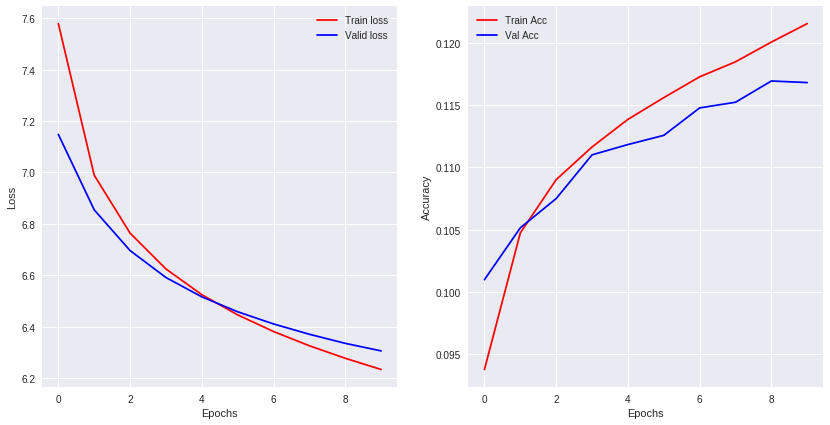

In [17]:
epoch = np.arange(max_epochs)
fig, axes = plt.subplots(figsize=(2*7,7), ncols=2, nrows=1)
ylabels = ['Loss', 'Accuracy']
legends = [['Train loss', 'Valid loss'], ['Train Acc', 'Val Acc']]
ydata = [[train_loss, valid_loss], [train_acc, valid_acc]]

for i, ax in enumerate(fig.axes): 
  ax.plot(epoch, ydata[i][0], 'r', epoch, ydata[i][1], 'b')
  ax.legend(legends[i])
  ax.set_xlabel('Epochs')
  ax.set_ylabel(ylabels[i])
plt.show()

# Notes 